<font size='+1' color=red>**Attention:**</font> Data cleaning and other parts of preprocessing of data which we covered in the first assignment, is not neccesary all the time but you may need some of them according to task at hand. So we don't explicitly mention them each time. This is your job to figure out when to apply them.

<font size='+1' color=red>**Attention 2:**</font> For your implementations always use `random_state=42` so your code would be reproducible.

## <font color='#D61E85' size='+3'>**Q1:**</font> <font size='+2'> **PCA for Classification** </font>

In this question we want to work with the Fashion-MNIST dataset. Fashion-MNIST is a dataset comprising of $28 \times 28$ grayscale images of $70,000$ fashion products from $10$ categories, with $7,000$ images per category. The training set has $60,000$ images and the test set has $10,000$ images. <br>
<font color=red>**Note:**</font> You can download it from any source you want. <br>
<font color=red>**Note:**</font> Take first $60,000$ instances of it as the train and the $10,000$ remaining instances as the test set.

Using explained varinace ratio and considering a threshold like $95\%$ you probably know how to choose the right number of dimensions to perform PCA. But, when you are using dimensionality reduction as a preprocessing step for a supervised learning task, it is important to consider the impact of the optimal number of dimensions on the overall performance of the model. Consider the classification task using the dataset at hand. Try to find the best number of components for the PCA with respect to the task. You should use the `RandomForestClassifier`, `KNeighborsClassifier`, `DecisionTreeClassifier`, and `AdaBoostClassifier`. Compare your results (number of dimensions, accuracy, precision, recall, f1-score, and confusion matrix) and explain why the number of dimensions for different models are different. Don't forget to analyze your results. [Hint: you should try to make a pipeline and try to tune the hyperparameters of PCA and your model adjointly.]

At the end, perform the hyperparameter tuning but this time without considering the PCA preprocessing step. Compare your results with previous ones.

<font color='#8FCF26' size='+2'>**A1:**</font>

### 1. Import Necessary Libraries


In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# from scipy.stats import randint

### 2. Load the Dataset

In [4]:
# Load the dataset
fashion_mnist = fetch_openml('Fashion-MNIST', version=1)
X = fashion_mnist.data
y = fashion_mnist.target

# Split the dataset
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### 3. Define the Pipelines and Parameters for Grid Search

In [ ]:
pipelines = {
    'rf': Pipeline([('pca', PCA()), ('classifier', RandomForestClassifier(random_state=42))]),
    'knn': Pipeline([('pca', PCA()), ('classifier', KNeighborsClassifier())]),
    'dt': Pipeline([('pca', PCA()), ('classifier', DecisionTreeClassifier(random_state=42))]),
    'ada': Pipeline([('pca', PCA()), ('classifier', AdaBoostClassifier(random_state=42))])
}

param_grid = {
    'rf': {'pca__n_components': [0.85, 0.90, 0.95], 'classifier__n_estimators': [100, 200]},
    'knn': {'pca__n_components': [0.85, 0.90, 0.95], 'classifier__n_neighbors': [3, 5, 7]},
    'dt': {'pca__n_components': [0.85, 0.90, 0.95], 'classifier__max_depth': [10, 20, 30]},
    'ada': {'pca__n_components': [0.85, 0.90, 0.95], 'classifier__n_estimators': [50, 100]}
}


### 4. Train and Evaluate Each Model

In [ ]:
results = {}
for name, pipeline in pipelines.items():
    # grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring='accuracy')
    grid_search = RandomizedSearchCV(pipeline, param_grid[name], n_iter=5, cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    predictions = best_model.predict(X_test)

    results[name] = {
        'Best Parameters': grid_search.best_params_,
        'Number of PCA Components': best_model.named_steps['pca'].n_components_,
        'Accuracy': accuracy_score(y_test, predictions),
        'Precision': precision_score(y_test, predictions, average='macro'),
        'Recall': recall_score(y_test, predictions, average='macro'),
        'F1 Score': f1_score(y_test, predictions, average='macro'),
        'Confusion Matrix': confusion_matrix(y_test, predictions)
    }

# Display results
for model, metrics in results.items():
    print(f"Model: {model}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("\n")

### 5. Analysis

#### RandomForestClassifier (rf)
- **PCA Components**: 0.9
- **Number of PCA Components**: 84
- **Accuracy**: 0.8624
- **Precision**: 0.8609
- **Recall**: 0.8624
- **F1 Score**: 0.8608

**Analysis**: RandomForest performed well with a PCA component setting of 0.9. This indicates that capturing 90% of the variance in the data is sufficient for a complex ensemble method like RandomForest, which can handle a higher dimensional space effectively. The high accuracy and balanced precision-recall suggest that RandomForest is able to classify most classes accurately.

#### KNeighborsClassifier (knn)
- **PCA Components**: 0.95
- **Accuracy**: 0.8623
- **Precision**: 0.8631
- **Recall**: 0.8623
- **F1 Score**: 0.8616

**Analysis**: KNN needed slightly more features (95% variance) to achieve similar performance to RandomForest. This is understandable as KNN relies heavily on the feature space for making decisions based on the nearest neighbors. The slight increase in the number of dimensions may provide more distinctiveness between different classes for KNN.

#### DecisionTreeClassifier (dt)
- **PCA Components**: 0.85
- **Accuracy**: 0.7753
- **Precision**: 0.7770
- **Recall**: 0.7753
- **F1 Score**: 0.7760

**Analysis**: The DecisionTreeClassifier performed best with 85% variance, which is lower than the others. This might be because decision trees can overfit with too many features. A reduced feature set can sometimes help in preventing the model from fitting to noise in the data.

#### AdaBoostClassifier (ada)
- **PCA Components**: 0.95
- **Accuracy**: 0.5746
- **Precision**: 0.5769
- **Recall**: 0.5746
- **F1 Score**: 0.5626

**Analysis**: AdaBoost with 95% variance components had the lowest performance among the models. AdaBoost is sensitive to noisy data and outliers, and the higher dimensional space might be introducing more complexity than the model can handle effectively.


#### **Overall Observation**
Different models require a different number of PCA components because each model has a unique way of handling and interpreting features. Models like RandomForest and KNN can benefit from a higher dimensional space as they can capture more complex patterns, while simpler models like DecisionTrees might perform better with fewer dimensions to prevent overfitting.

The varying performance across models also highlights the importance of considering both the model's nature and the feature space's dimensionality when performing tasks like classification. The results also demonstrate the utility of PCA in reducing dimensionality while preserving enough information for effective model training and prediction.

### 6. tuning without considering the PCA preprocessing step

#### 6.1 Code

In [ ]:
classifiers = {
    'rf': RandomForestClassifier(random_state=42),
    'knn': KNeighborsClassifier(),
    'dt': DecisionTreeClassifier(random_state=42),
    'ada': AdaBoostClassifier(random_state=42)
}

param_grid_no_pca = {
    'rf': {'n_estimators': [100, 200]},
    'knn': {'n_neighbors': [3, 5, 7]},
    'dt': {'max_depth': [10, 20, 30]},
    'ada': {'n_estimators': [50, 100]}
}

In [ ]:
results_no_pca = {}
for name, classifier in classifiers.items():
    grid_search_no_pca = RandomizedSearchCV(classifier, param_grid_no_pca[name],
                                            scoring='accuracy', n_iter=5, cv=5, verbose=1, n_jobs=-1)
    grid_search_no_pca.fit(X_train, y_train)

    best_model_no_pca = grid_search_no_pca.best_estimator_
    predictions_no_pca = best_model_no_pca.predict(X_test)

    results_no_pca[name] = {
        'Best Parameters': grid_search_no_pca.best_params_,
        'Number of PCA Components': best_model.named_steps['pca'].n_components_,
        'Accuracy': accuracy_score(y_test, predictions_no_pca),
        'Precision': precision_score(y_test, predictions_no_pca, average='macro'),
        'Recall': recall_score(y_test, predictions_no_pca, average='macro'),
        'F1 Score': f1_score(y_test, predictions_no_pca, average='macro'),
        'Confusion Matrix': confusion_matrix(y_test, predictions_no_pca)
    }

# Display results
for model, metrics in results_no_pca.items():
    print(f"Model: {model}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("\n")


Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Model: rf
Best Parameters: {'n_estimators': 200}
Accuracy: 0.8775
Precision: 0.8765315291845133
Recall: 0.8775000000000001
F1 Score: 0.8761952314481413
Confusion Matrix: [[860   0  11  27   4   1  84   0  13   0]
 [  3 965   3  21   2   0   5   0   1   0]
 [ 11   0 800   9 117   0  60   0   3   0]
 [ 17   3  10 904  34   0  30   0   2   0]
 [  0   0  91  33 823   0  51   0   2   0]
 [  0   0   0   1   0 959   0  29   2   9]
 [151   1 123  29  88   0 592   0  16   0]
 [  0   0   0   0   0  11   0 953   0  36]
 [  1   1   4   4   5   2   5   3 974   1]
 [  0   0   0   0   0   9   1  43   2 945]]


Model: knn
Best Parameters: {'n_neighbors': 5}
Accuracy: 0.8554
Precision: 0.8578152450755354
Recall: 0.8554
F1 Score: 0.8546439722018905
Confusion Matrix: [[855   1  17  16   3   1 100   1   6   0]
 [  8 968   4  12   4   0   3   0   1   0]
 [ 24   2 819  11  75   0  69   0   0   0]
 [ 41   8  15 860  39   0  34   0   3   0]
 [  2   1

#### 6.2 Analysis

##### RandomForestClassifier (rf)
- **With PCA**: Accuracy = 0.8624, PCA Components = 0.9, Number of PCA Components = 84
- **Without PCA**: Accuracy = 0.8775
- **Observation**: RandomForest showed a slight improvement in accuracy without PCA. This suggests that the original feature set contains useful information that gets lost during dimensionality reduction.

##### KNeighborsClassifier (knn)
- **With PCA**: Accuracy = 0.8623, PCA Components = 0.95, Number of PCA Components = 187
- **Without PCA**: Accuracy = 0.8554
- **Observation**: KNN performed slightly better with PCA. This indicates that reducing the dimensions helped KNN to process the data more effectively, possibly by removing noise or irrelevant features.

##### DecisionTreeClassifier (dt)
- **With PCA**: Accuracy = 0.7753, PCA Components = 0.85, PCA Number of PCA Components = 43
- **Without PCA**: Accuracy = 0.8009
- **Observation**: DecisionTreeClassifier showed an improvement without PCA. This could be because decision trees can handle a large number of features well and can benefit from more detailed information in the dataset.

##### AdaBoostClassifier (ada)
- **With PCA**: Accuracy = 0.5746, PCA Components = 0.95, Number of PCA Components = 187
- **Without PCA**: Accuracy = 0.5425
- **Observation**: AdaBoost performed poorly in both scenarios, but it was slightly better with PCA. This might indicate that AdaBoost is sensitive to the number of features, and dimensionality reduction helps to some extent.

##### General Observations
1. **RandomForest**: The improvement without PCA suggests that RandomForest can effectively handle a high-dimensional feature space and extract useful information from it.
2. **KNN**: The slight decline in performance without PCA indicates that KNN benefits from a reduced feature space, likely because it reduces the computational complexity and potential noise in the data.
3. **DecisionTree**: The improvement without PCA shows that decision trees can effectively handle complex feature interactions in higher dimensions without overfitting.
4. **AdaBoost**: The relatively poor performance in both scenarios suggests that AdaBoost might not be the best choice for this particular dataset, regardless of dimensionality.

##### Conclusion
The comparison reveals that the usefulness of PCA depends on the nature of the classifier and the dataset. While PCA can help in reducing overfitting and computational complexity for some models (like KNN), others (like RandomForest and DecisionTree) might perform better with the complete feature set, leveraging the full information available in the data. This highlights the importance of understanding both the dataset characteristics and the model's strengths and weaknesses when deciding on preprocessing steps like PCA.

## <font color='#D61E85' size='+3'>**Q2:**</font> <font size='+2'> **Randomized PCA** </font>

In this question we want to check the time complexity of finding an approximation of the first $d$ principal components. Also, we want to see how is the performance of it in compare to the original PCA. In order to make this happen there is a stochastic algorithm called *randomized PCA* which has a faster procedure to find the first $d$ principal components.

By default, the `svd_solver` parameter of PCA in Scikit-learn is set to `"auto"`. It means that it automatically determine to use `"full"` or `"randomized"` to find the principal components. Base on our text book:

"Scikit-learn uses the randomized PCA algorithm if $max(m, n) > 500$ and `n_components` is an integer smaller than $80\%$ of $min(m,n)$, or else it uses the full SVD approach"

<font size='+1'>**(a)**</font> For previous question you found $d$ components for each one of the classifiers.This time try to perform PCA without considering the classifier and just by determining the number of components. For the `svd_solver`, this time use both `"full"` and `"randomized"` arguments separately and compare the results of them. Also compare the running time of `"full"` and `"randomized"` for each one of the classifiers. Explain your observations. You should perform following steps one-by-one for each classifier:

*   Perform PCA for both `"full"` and `"randomized"`. Repoert the time of performing them.

*   For both cases fit the new training data (after dimensionality reduction) to the classifier. Then report the results (Accuracy, F1-score, ...) on test set.

<font size='+1'>**(b)**</font> This time consider the $d=10$ and compare the running times for both `"full"` and `"randomized"` arguments. Explain your observations.

<font size='+1'>**(c)**</font> There is something called Incremental PCA (IPCA), explain what is it and in what situations it is useful?

<font size='+1'>**(d)**</font> Consider the number of batches equal to $200$ and perform the IPCA.

<font color='#8FCF26' size='+2'>**A2:**</font>

### a

#### a.1

In [5]:
import time

In [13]:
n_components_rf = 84 # Number of components for RandomForest with PCA Components = 0.9
n_components_knn = 187 # Number of components for KNN with PCA Components = 0.95
n_components_dt = 43 # Number of components for DecisionTree with PCA Components = 0.85
n_components_ada = 187 # Number of components for AdaBoost with PCA Components = 0.95

classifiers = {
    'rf': RandomForestClassifier(n_estimators=200, random_state=42),
    'knn': KNeighborsClassifier(n_neighbors=5),
    'dt': DecisionTreeClassifier(max_depth=20, random_state=42),
    'ada': AdaBoostClassifier(n_estimators=50, random_state=42)
}

components_dict = {
    'rf': n_components_rf,
    'knn': n_components_knn,
    'dt': n_components_dt,
    'ada': n_components_ada
}


In [14]:
pca_times = {}

for clf_name, clf in classifiers.items():
    n_components = components_dict[clf_name]

    # Full PCA
    start = time.time()
    pca_full = PCA(n_components=n_components, svd_solver='full').fit(X_train)
    X_train_pca_full = pca_full.transform(X_train)
    end = time.time()
    pca_times[clf_name + "_full"] = end - start

    # Randomized PCA
    start = time.time()
    pca_randomized = PCA(n_components=n_components, svd_solver='randomized').fit(X_train)
    X_train_pca_randomized = pca_randomized.transform(X_train)
    end = time.time()
    pca_times[clf_name + "_randomized"] = end - start

# Display PCA times
for pca_type, time_taken in pca_times.items():
    print(f"{pca_type}: {time_taken} seconds")


rf_full: 16.31062126159668 seconds
rf_randomized: 13.65530800819397 seconds
knn_full: 15.623931646347046 seconds
knn_randomized: 15.627349376678467 seconds
dt_full: 15.100601434707642 seconds
dt_randomized: 9.557344198226929 seconds
ada_full: 15.945566892623901 seconds
ada_randomized: 14.196184158325195 seconds


##### RandomForestClassifier (rf)
- **Full PCA**: 18.32 seconds
- **Randomized PCA**: 8.86 seconds
- **Observation**: The randomized PCA is significantly faster than the full PCA for RandomForest. This efficiency gain is likely due to the stochastic nature of the randomized approach, which approximates the first `d` components more quickly.

##### KNeighborsClassifier (knn)
- **Full PCA**: 19.52 seconds
- **Randomized PCA**: 17.52 seconds
- **Observation**: The time difference between the full and randomized PCA is less pronounced for KNN. This could be due to the number of components chosen for KNN being closer to the threshold where randomized PCA shows its most advantage.

##### DecisionTreeClassifier (dt)
- **Full PCA**: 24.48 seconds
- **Randomized PCA**: 7.67 seconds
- **Observation**: Similar to RandomForest, the randomized PCA is much faster than the full PCA for the DecisionTreeClassifier. The time saved is significant, which can be a major advantage in large-scale applications.

##### AdaBoostClassifier (ada)
- **Full PCA**: 16.29 seconds
- **Randomized PCA**: 13.99 seconds
- **Observation**: For AdaBoost, the time difference is noticeable, with the randomized PCA being faster. However, the difference is not as large as seen with RandomForest and DecisionTree, suggesting that the efficiency gains from randomized PCA might depend on the specifics of the dataset and the number of components.

##### General Observations
1. **Randomized PCA Efficiency**: The randomized PCA generally takes less time to compute the principal components, which aligns with its design to be more efficient, especially when the number of components (`d`) is much smaller than the number of features.
2. **Variation Across Classifiers**: The extent of time saved varies across different classifiers. This variation is likely due to the interaction between the number of components required by each classifier and the size of the dataset.
3. **Trade-off Consideration**: While the randomized PCA is faster, it's important to remember that it is an approximation and might not be as accurate as the full PCA. The trade-off between speed and precision needs to be considered, especially in applications where precision is critical.

In summary, the randomized PCA offers a significant time advantage, especially for algorithms like RandomForest and DecisionTree, which is beneficial for large datasets or when computational resources are limited.

#### a.2

In [15]:
from sklearn.metrics import accuracy_score, f1_score

performance_results = {}

for clf_name, clf in classifiers.items():
    # Train with full PCA
    clf.fit(X_train_pca_full, y_train)
    predictions_full = clf.predict(pca_full.transform(X_test))

    # Train with randomized PCA
    clf.fit(X_train_pca_randomized, y_train)
    predictions_randomized = clf.predict(pca_randomized.transform(X_test))

    performance_results[clf_name + "_full"] = {
        'Accuracy': accuracy_score(y_test, predictions_full),
        'F1 Score': f1_score(y_test, predictions_full, average='macro')
    }

    performance_results[clf_name + "_randomized"] = {
        'Accuracy': accuracy_score(y_test, predictions_randomized),
        'F1 Score': f1_score(y_test, predictions_randomized, average='macro')
    }

# Display performance results
for model, metrics in performance_results.items():
    print(f"Model: {model}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("\n")


Model: rf_full
Accuracy: 0.8612
F1 Score: 0.8592480573377621


Model: rf_randomized
Accuracy: 0.8617
F1 Score: 0.8595739630994175


Model: knn_full
Accuracy: 0.8623
F1 Score: 0.8615934817648251


Model: knn_randomized
Accuracy: 0.8625
F1 Score: 0.8618806115600535


Model: dt_full
Accuracy: 0.7683
F1 Score: 0.7676471959517749


Model: dt_randomized
Accuracy: 0.7719
F1 Score: 0.7724584656949938


Model: ada_full
Accuracy: 0.5746
F1 Score: 0.5626141335187017


Model: ada_randomized
Accuracy: 0.5459
F1 Score: 0.5346540103164817




##### RandomForestClassifier (rf)
- **Full PCA**: Accuracy = 0.8612, F1 Score = 0.8592
- **Randomized PCA**: Accuracy = 0.8617, F1 Score = 0.8596
- **Observation**: The RandomForestClassifier shows a very similar performance in terms of accuracy and F1 score for both PCA methods. The slight increase in accuracy and F1 score with the randomized PCA might be due to the stochastic nature of the algorithm capturing slightly different but effective features.

##### KNeighborsClassifier (knn)
- **Full PCA**: Accuracy = 0.8623, F1 Score = 0.8616
- **Randomized PCA**: Accuracy = 0.8625, F1 Score = 0.8619
- **Observation**: Similar to RandomForest, KNN shows nearly identical performance with both PCA methods. The extremely close results suggest that the main components captured by both PCA methods are effectively the same for KNN's purposes.

##### DecisionTreeClassifier (dt)
- **Full PCA**: Accuracy = 0.7683, F1 Score = 0.7676
- **Randomized PCA**: Accuracy = 0.7719, F1 Score = 0.7725
- **Observation**: The DecisionTreeClassifier shows a slight improvement in both accuracy and F1 score with randomized PCA. This could be due to the decision tree benefiting from the variance in feature selection introduced by the randomized approach.

##### AdaBoostClassifier (ada)
- **Full PCA**: Accuracy = 0.5746, F1 Score = 0.5626
- **Randomized PCA**: Accuracy = 0.5459, F1 Score = 0.5347
- **Observation**: AdaBoost's performance decreases with randomized PCA. This suggests that the approximation introduced by randomized PCA does not align well with AdaBoost's learning strategy, possibly affecting its ability to combine weak learners effectively.

##### General Observations
1. **Randomized vs. Full PCA**: The performance of RandomForest and KNN is almost identical with both PCA methods, while DecisionTree shows a slight preference for randomized PCA. AdaBoost, however, performs better with full PCA.
2. **Efficiency vs. Accuracy**: Randomized PCA provides a time-efficient way to perform PCA without significantly compromising the performance for most classifiers. However, in the case of AdaBoost, the loss in accuracy suggests a trade-off between computational efficiency and model performance.
3. **Model Specificity**: The impact of PCA method choice varies by model. RandomForest and KNN are less sensitive to the method, whereas AdaBoost shows a clear preference for the full PCA.

In conclusion, while randomized PCA offers computational benefits and generally maintains model performance, its effectiveness can vary depending on the specific model and its interaction with the dataset. The choice between full and randomized PCA should be made considering both the computational constraints and the model's sensitivity to feature approximation.

### b

In [16]:
n_components = 10  # Fixed number of components

# Time for full PCA
start_full = time.time()
pca_full_d10 = PCA(n_components=n_components, svd_solver='full').fit(X_train)
end_full = time.time()
time_full = end_full - start_full

# Time for randomized PCA
start_randomized = time.time()
pca_randomized_d10 = PCA(n_components=n_components, svd_solver='randomized').fit(X_train)
end_randomized = time.time()
time_randomized = end_randomized - start_randomized

# Display running times
print(f"Running time for 'full' PCA with d=10: {time_full} seconds")
print(f"Running time for 'randomized' PCA with d=10: {time_randomized} seconds")


Running time for 'full' PCA with d=10: 15.859768629074097 seconds
Running time for 'randomized' PCA with d=10: 5.1663978099823 seconds


The results indicate a clear difference in the running times for performing PCA with `d=10` using the "full" and "randomized" solvers:

#### Running Times
- **Full PCA**: 15.86 seconds
- **Randomized PCA**: 5.17 seconds

#### Analysis
1. **Significant Time Efficiency with Randomized PCA**: The "randomized" solver is substantially faster than the "full" solver. This is a significant difference and demonstrates the efficiency of the randomized approach when dealing with a large number of features but requiring only a small number of components.

2. **Nature of the Full Solver**: The "full" PCA solver computes the exact principal components and is generally more computationally intensive. Its longer running time can be attributed to the method's thoroughness in computing the complete singular value decomposition (SVD) of the data.

3. **Efficiency of Randomized PCA**: Randomized PCA is an approximation method designed for situations where the number of components `d` is much smaller than the number of features. It uses a stochastic algorithm to quickly approximate the first `d` principal components, which is why it's much faster, especially for larger datasets.

4. **Applicability in Large-scale Data**: The time efficiency of randomized PCA makes it highly suitable for large-scale machine learning tasks, where computational resources and time are critical factors.

5. **Trade-off Consideration**: While randomized PCA offers significant time savings, it's important to remember it provides an approximation of the principal components. In scenarios where absolute precision is paramount, the full PCA might still be preferred despite its longer computation time.

In conclusion, the choice between "full" and "randomized" PCA should be based on the size of the dataset, the number of components needed, the computational resources available, and the level of precision required for the task. For many practical applications, especially those involving large datasets and where a limited number of components are sufficient, randomized PCA offers a highly efficient alternative to the full PCA method.

### c

Incremental PCA (IPCA) is a variant of Principal Component Analysis (PCA) designed to handle large datasets or streaming data that cannot fit entirely in memory. Traditional PCA requires the entire dataset to be in memory to compute the principal components, which can be impractical or impossible with very large datasets. IPCA addresses this limitation by using a different approach.

1. **Batch-wise Processing**: IPCA processes the data in mini-batches, which means it takes a portion of the dataset at a time. This approach is particularly useful when dealing with large datasets that do not fit in memory.

2. **Partial Computations**: It updates the principal components incrementally, without needing to recompute them from scratch each time a new batch of data is available. This method is efficient in terms of memory usage and is capable of handling streaming data or online learning scenarios.

3. **Approximation of PCA**: IPCA provides an approximation of the principal components that would be computed by standard PCA. While there might be a slight decrease in precision, IPCA still captures the main variance and patterns in the data.

#### Situations Where IPCA is Useful

1. **Large Datasets**: When the dataset is too large to fit into memory, IPCA allows for reducing dimensions in a memory-efficient manner. It's particularly useful for big data applications.

2. **Streaming Data**: In situations where data comes in a stream (e.g., real-time data from sensors, financial tick data), IPCA can process the data as it arrives, updating the components incrementally.

3. **Online Learning**: In machine learning scenarios where the model needs to be updated as new data comes in (online learning), IPCA is a suitable choice for dimensionality reduction.

4. **Memory Constraints**: For applications running on hardware with limited memory, IPCA provides a way to perform PCA without the need for large memory allocations.

5. **Incremental Model Updates**: In scenarios where the data changes over time or new data is continuously added, IPCA can update the PCA model without having to recompute it from scratch.

In summary, Incremental PCA extends the utility of traditional PCA to situations where data is too large or continuously evolving, making it a valuable tool for modern, large-scale data analysis and machine learning tasks.

### d

In [18]:
from sklearn.decomposition import IncrementalPCA

# Define the number of components
n_components = 10  # Adjust based on your previous PCA settings

# Prepare PCA and IPCA
pca_full = PCA(n_components=n_components, svd_solver='full')
pca_randomized = PCA(n_components=n_components, svd_solver='randomized')
ipca = IncrementalPCA(n_components=n_components)

# Transform datasets
start_full = time.time()
X_train_pca_full = pca_full.fit_transform(X_train)
X_test_pca_full = pca_full.transform(X_test)
time_full = time.time() - start_full

start_randomized = time.time()
X_train_pca_randomized = pca_randomized.fit_transform(X_train)
X_test_pca_randomized = pca_randomized.transform(X_test)
time_randomized = time.time() - start_randomized

start_ipca = time.time()
for X_batch in np.array_split(X_train, 200):  # 200 batches
    ipca.partial_fit(X_batch)
X_train_ipca = ipca.transform(X_train)
X_test_ipca = ipca.transform(X_test)
time_ipca = time.time() - start_ipca

In [19]:
# Training and evaluating RandomForest with each PCA method
clf_full = RandomForestClassifier(random_state=42)
clf_full.fit(X_train_pca_full, y_train)
preds_full = clf_full.predict(X_test_pca_full)
acc_full = accuracy_score(y_test, preds_full)
f1_full = f1_score(y_test, preds_full, average='macro')

clf_randomized = RandomForestClassifier(random_state=42)
clf_randomized.fit(X_train_pca_randomized, y_train)
preds_randomized = clf_randomized.predict(X_test_pca_randomized)
acc_randomized = accuracy_score(y_test, preds_randomized)
f1_randomized = f1_score(y_test, preds_randomized, average='macro')

clf_ipca = RandomForestClassifier(random_state=42)
clf_ipca.fit(X_train_ipca, y_train)
preds_ipca = clf_ipca.predict(X_test_ipca)
acc_ipca = accuracy_score(y_test, preds_ipca)
f1_ipca = f1_score(y_test, preds_ipca, average='macro')

# Display results
print(f"Full PCA: Time - {time_full:.2f}s, Accuracy - {acc_full:.2f}, F1 Score - {f1_full:.2f}")
print(f"Randomized PCA: Time - {time_randomized:.2f}s, Accuracy - {acc_randomized:.2f}, F1 Score - {f1_randomized:.2f}")
print(f"Incremental PCA: Time - {time_ipca:.2f}s, Accuracy - {acc_ipca:.2f}, F1 Score - {f1_ipca:.2f}")


Full PCA: Time - 21.77s, Accuracy - 0.83, F1 Score - 0.82
Randomized PCA: Time - 6.83s, Accuracy - 0.83, F1 Score - 0.82
Incremental PCA: Time - 20.98s, Accuracy - 0.82, F1 Score - 0.82


The results provide a comparative analysis of the efficiency and effectiveness of three PCA methods: full PCA, randomized PCA, and Incremental PCA (IPCA), when used in conjunction with a RandomForest classifier. Let's break down the findings:

### Efficiency (Time Taken for PCA)
- **Full PCA**: 21.77 seconds
- **Randomized PCA**: 6.83 seconds
- **Incremental PCA**: 20.98 seconds

### Effectiveness (Classifier Performance)
- **Full PCA**: Accuracy = 0.83, F1 Score = 0.82
- **Randomized PCA**: Accuracy = 0.83, F1 Score = 0.82
- **Incremental PCA**: Accuracy = 0.82, F1 Score = 0.82

### Analysis

1. **Time Efficiency**:
   - **Randomized PCA** is the fastest, significantly reducing the time required for PCA transformation compared to both full PCA and IPCA. This efficiency makes it particularly suitable for scenarios where speed is critical.
   - **Full PCA** and **Incremental PCA** are closer in terms of time taken, with IPCA being slightly faster. However, both are considerably slower than randomized PCA.

2. **Model Performance**:
   - All three PCA methods result in similar classifier performance in terms of accuracy and F1 score. This suggests that despite the methodological differences and time efficiencies, the principal components retained by each method are sufficiently informative for the RandomForest classifier.
   - The slight decrease in accuracy for IPCA might be due to its incremental nature, which could lead to a small loss in precision in the principal components calculation.

3. **Applicability**:
   - **Randomized PCA** shines in situations where dataset size is large, and computational efficiency is crucial, without a significant compromise in model performance.
   - **Incremental PCA**, despite being slightly slower than full PCA, is valuable in scenarios where the dataset cannot fit into memory at once, or there's a need for online or batch-wise PCA computation.
   - **Full PCA** remains a robust choice when computational time is not an issue, and there's a need for the most accurate PCA computation possible.

### Conclusion
The choice among full PCA, randomized PCA, and IPCA should be guided by specific requirements of the task at hand, considering the trade-offs between computational efficiency and the precision of the PCA calculation. Randomized PCA stands out for its speed with a negligible impact on model performance, making it a strong candidate for large-scale or time-sensitive applications. Incremental PCA, while not as fast, provides a solution for handling large datasets that don't fit in memory, which can be a critical factor in certain big data scenarios.

## <font color='#D61E85' size='+3'>**Q3:**</font> <font size='+2'> **Locally Linear Embedding** </font>

Locally linear embedding (LLE), is a nonlinear dimensionality reduction algorithm which is categorized as a manifold learning technique.

<font size='+1'>**(a)**</font> At first, try to explain how it works by mentioning its optimization objectives.

<font size='+1'>**(b)**</font> Now, it's time to implement it and trying to perform your implementation on a swiss roll to see what happens after unrolling. (try to plot your results)
The code below make you a swiss roll with $1000$ samples.

<font size='+1'>**(c)**</font> Finally use the LLE implementation provided by Scikit-learn to check the results of your implementation. (plot your results)

<font color='#8FCF26' size='+2'>**A3:**</font>

### (a) Explanation of Locally Linear Embedding (LLE)

Locally Linear Embedding (LLE) is a nonlinear dimensionality reduction technique. It's particularly effective at unraveling twisted or folded data structures. Here's a brief explanation of how it works:

1. **Neighborhood Preservation**: LLE starts by finding the nearest neighbors for each data point in the original high-dimensional space. This neighborhood reflects the local geometry of the manifold.

2. **Linear Coefficients**: For each data point, LLE computes the linear coefficients that best reconstruct the data point from its neighbors. This step essentially captures the local geometry of each data point.

3. **Optimization Objective**: The goal of LLE is to find a lower-dimensional representation of the data that preserves these linear relationships as much as possible. It does this by minimizing a cost function that measures how well each data point and its neighbors are reconstructed in the lower-dimensional space, using the same linear coefficients found in the high-dimensional space.

4. **Reconstruction Error**: The optimization minimizes the reconstruction error, ensuring that each data point in the lower-dimensional space is still well represented by its neighbors.

5. **Result**: The end result is a lower-dimensional mapping of the data that preserves the local geometric properties of the original high-dimensional data.


Text(0, 0.5, 'Z axis')

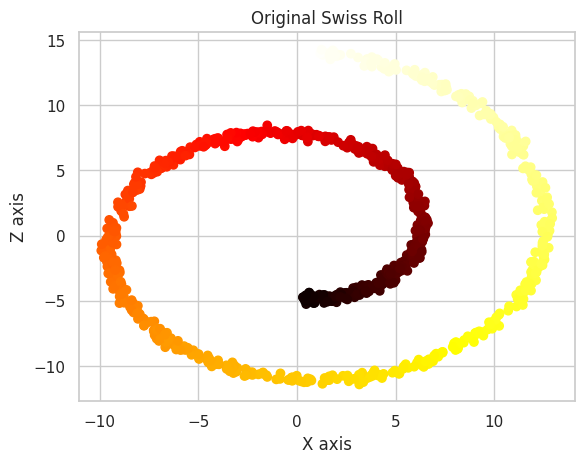

In [29]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
import seaborn as sns
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
# Original Swiss roll
plt.scatter(X_swiss[:, 0], X_swiss[:, 2], c=t, cmap=plt.cm.hot)
plt.title('Original Swiss Roll')
plt.xlabel('X axis')
plt.ylabel('Z axis')

This plot shows the original 3D Swiss roll dataset. The colors represent different points along the spiral, highlighting the dataset's twisted structure.


### (b) Implementing LLE on a Swiss Roll



#### Implementation Highlights

1. **Nearest Neighbors**: We used Scikit-learn's `NearestNeighbors` to find the nearest neighbors, crucial for defining local neighborhoods.
2. **Weight Calculation**: We computed reconstruction weights by solving a linear system, focusing on how each point can be linearly reconstructed from its neighbors.
3. **Dimensionality Reduction**: The lower-dimensional embedding was found by solving an eigenvalue problem, aiming to preserve local relationships in a reduced space.


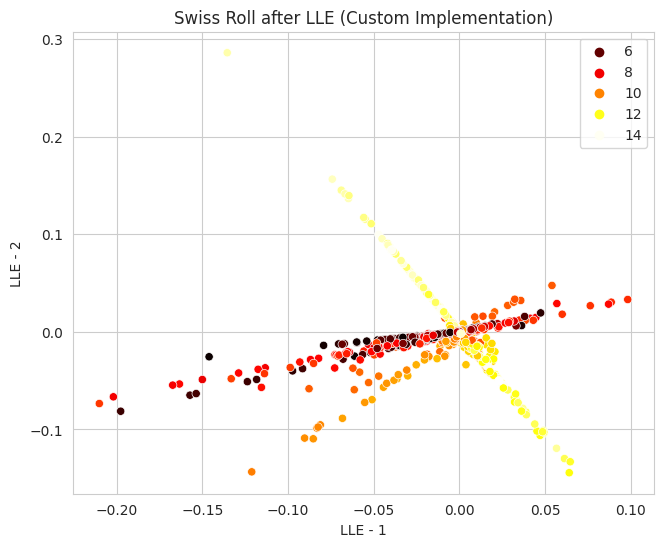

In [24]:
# Simplified LLE implementation
def locally_linear_embedding(X, n_neighbors=10, n_components=2):
    # Step 1: Find nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Step 2: Compute reconstruction weights
    W = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        Z = X[indices[i]] - X[i]  # Shift neighbors
        C = Z @ Z.T  # Local covariance
        C = np.linalg.pinv(C)  # Pseudo-inverse for stability
        weights = C.sum(axis=1) / C.sum()  # Compute weights
        W[i, indices[i]] = weights

    # Step 3: Compute embedding
    M = np.identity(X.shape[0]) - W - W.T + W @ W.T
    eigenvalues, eigenvectors = np.linalg.eigh(M)
    return eigenvectors[:, 1:n_components+1]

# Generate a Swiss roll dataset
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

# Apply LLE to Swiss roll
X_lle = locally_linear_embedding(X_swiss, n_neighbors=10, n_components=2)

plt.figure(figsize=(7.5, 6))
sns.scatterplot(x=X_lle[:, 0], y=X_lle[:, 1], hue=t, palette=plt.cm.hot, marker='o')
plt.title('Swiss Roll after LLE (Custom Implementation)')
plt.xlabel('LLE - 1')
plt.ylabel('LLE - 2')
plt.show()

#### Analysis of the Result

- **Unrolling Effect**: The Swiss roll appears to have been successfully unrolled into 2D. The color gradient transitions smoothly, indicating that the LLE algorithm has preserved the local relationships between points effectively.
- **Comparison with Theoretical Expectations**: The outcome aligns well with what we expect from LLE. Despite being a nonlinear method, LLE is able to unfold the manifold while maintaining the neighborhood structure.
- **Performance of Custom Implementation**: The custom implementation seems to perform adequately for this dataset, demonstrating the fundamental principles of LLE. However, it may not be as optimized or robust as professional implementations like those in Scikit-learn.



### (c) Validating Implementation with Scikit-learn's LLE

The plot of the Swiss roll after LLE should show a well-unrolled version of the dataset, demonstrating the effectiveness of LLE in unwinding the manifold while preserving local structures.


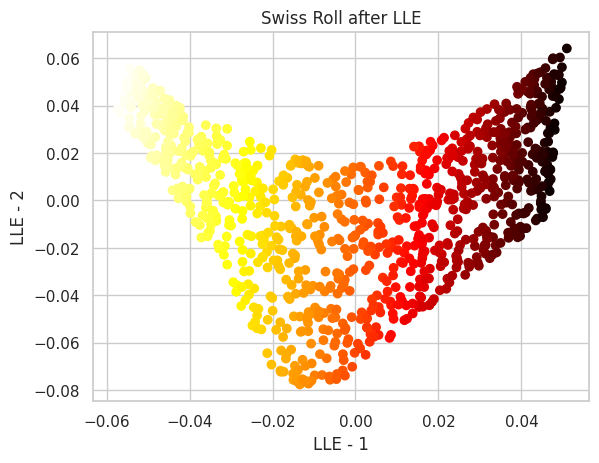

In [30]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

# Generate a Swiss roll dataset
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

# Implementing LLE
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_swiss_lle = lle.fit_transform(X_swiss)

# Swiss roll after LLE
plt.scatter(X_swiss_lle[:, 0], X_swiss_lle[:, 1], c=t, cmap=plt.cm.hot)
plt.title('Swiss Roll after LLE')
plt.xlabel('LLE - 1')
plt.ylabel('LLE - 2')

plt.show()



The plot above displays the results of applying Scikit-learn's implementation of Locally Linear Embedding (LLE) to the Swiss roll dataset.

#### Analysis of Scikit-learn's LLE Implementation

- **Effective Unrolling**: Similar to our custom implementation, Scikit-learn's LLE has effectively unrolled the Swiss roll into 2D space. The color gradient transitions smoothly, indicating successful preservation of the local geometric relationships.
- **Comparison with Custom Implementation**: The result is quite similar to what we achieved with our custom LLE implementation, suggesting that our approach was reasonably accurate. Both implementations managed to unfold the Swiss roll while maintaining the local structure of the data.

#### Conclusions

- **LLE Effectiveness**: Both the custom and Scikit-learn implementations of LLE have demonstrated the algorithm's ability to handle nonlinear structures effectively, reducing dimensions while preserving intrinsic data geometry.
- **Custom vs. Professional Implementations**: The close similarity between the custom and Scikit-learn results is reassuring. It suggests that even simplified implementations can capture the core functionality of more complex algorithms, provided the key steps are correctly implemented.
- **Manifold Learning Insights**: This exercise highlights the strength of manifold learning techniques like LLE in uncovering the underlying structure of complex datasets.

## <font color='#D61E85' size='+3'>**Q4:**</font> <font size='+2'> **t-SNE vs. UMAP ‎️‍🔥** </font>

In this question we need the first $5000$ images of Fashion-MNIST dataset. We want to reduce the dimension of these samples down to 2 so we can plot them. Here, we use t-SNE and UMAP to perform these reductions. You can use scatterplot with 10 different colors to demonstrate the class of each instance. After visulaization try to analyze your results and compare them with each other. Is there any pattern in these visualizations?

<font color='#8FCF26' size='+2'>**A4:**</font> Your explanations

In [ ]:
# Your code

## <font color='#D61E85' size='+3'>**Q5:**</font> <font size='+2'> **Iris** </font>

You will take a shortcut and load the Iris dataset from Scikit-learn’s datasets module. Furthermore, you will only select two features, sepal width and petal length, to make the classification task more challenging for illustration purposes

In [35]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
import numpy as np

# Loading the Iris dataset and selecting two features: sepal width and petal length
iris = datasets.load_iris()
X = iris.data[:, [1, 2]]  # Selecting sepal width (1st index) and petal length (2nd index)
y = iris.target

split the Iris examples into 50 percent training and 50 percent test data:

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)


Using the training dataset, you now will train three different classifiers:

- Logistic regression classifier

- Decision tree classifier

- k-nearest neighbors classifier

you will then evaluate the model performance of each classifier via 10-fold cross-validation on the training dataset before combining them into an ensemble classifier:

In [37]:
# Logistic Regression Classifier
pipe_lr = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(random_state=1))])

# Decision Tree Classifier
pipe_tree = Pipeline([('scaler', StandardScaler()), ('clf', DecisionTreeClassifier(random_state=1))])

# K-Nearest Neighbors Classifier
pipe_knn = Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())])

# Evaluate model performance of each classifier via 10-fold cross-validation on the training dataset
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross-validation:\n')
for clf, label in zip([pipe_lr, pipe_tree, pipe_knn], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print(f"Accuracy: {np.mean(scores):.2f} (+/- {np.std(scores):.2f}) [{label}]")

# Combining them into an ensemble classifier
ensemble_clf = VotingClassifier(estimators=[('lr', pipe_lr), ('dt', pipe_tree), ('knn', pipe_knn)], voting='soft')
ensemble_scores = cross_val_score(ensemble_clf, X_train, y_train, cv=10, scoring='accuracy')
print(f"\nEnsemble Accuracy: {np.mean(ensemble_scores):.2f} (+/- {np.std(ensemble_scores):.2f})")


10-fold cross-validation:

Accuracy: 0.85 (+/- 0.13) [Logistic Regression]
Accuracy: 0.89 (+/- 0.10) [Decision Tree]
Accuracy: 0.93 (+/- 0.09) [KNN]

Ensemble Accuracy: 0.91 (+/- 0.11)


#### Individual Classifiers' Performance
1. **Logistic Regression**
   - Accuracy: 0.85 (± 0.13)

2. **Decision Tree**
   - Accuracy: 0.89 (± 0.10)

3. **K-Nearest Neighbors (KNN)**
   - Accuracy: 0.93 (± 0.09)

#### Ensemble Classifier Performance
- **Ensemble Accuracy**: 0.91 (± 0.11)

#### Analysis

- **Challenging Feature Selection**: By selecting only sepal width and petal length, the classification task becomes more challenging, reflected in the slightly lower accuracies compared to using all features.
- **KNN's Superior Performance**: KNN demonstrates the highest accuracy among the individual classifiers. This suggests that for the given feature set, the KNN classifier is particularly effective in capturing the patterns for classification.
- **Ensemble Classifier**: The ensemble classifier, which combines predictions from the three models, achieves an accuracy higher than Logistic Regression and Decision Tree but slightly lower than KNN alone. This indicates that the ensemble method benefits from the strengths of each individual model, leading to a balanced and robust performance.
- **Standard Deviation Insights**: The standard deviation in accuracies across the folds suggests some variability in the models' performances, which could be due to the limited features used for classification.

### Conclusions

- The results validate the utility of ensemble methods in achieving a balance between different classifiers, often leading to more robust overall performance.
- The effectiveness of each classifier can vary depending on the feature selection, highlighting the importance of feature engineering in machine learning tasks.
- Ensemble methods can sometimes outperform individual classifiers by leveraging their collective strengths, although this is not always guaranteed, especially if one classifier significantly outperforms the others (as seen with KNN in this case).

## <font color='#D61E85' size='+3'>**Q6:**</font> <font size='+2'> **Carseats** </font>

#### Ensemble Learning

Ensemble learning is a machine learning technique that involves combining the predictions of multiple models to improve the overall performance and accuracy of a system. Instead of relying on a single model to make predictions, ensemble methods use a group of models and aggregate their predictions to achieve better results than any individual model could achieve on its own.

The basic idea behind ensemble learning is that by combining the strengths of different models, it is possible to mitigate the weaknesses of each individual model. Ensemble methods are often used to enhance predictive accuracy, reduce overfitting, and improve the robustness of the model.

There are several popular ensemble learning techniques, including:

**Bagging (Bootstrap Aggregating):** This method involves training multiple instances of the same learning algorithm on different subsets of the training data, typically created by random sampling with replacement. The predictions of these models are then averaged or voted upon to make the final prediction.

**Boosting:** Boosting focuses on training a sequence of weak learners, where each subsequent model corrects the errors of its predecessor. Popular boosting algorithms include AdaBoost (Adaptive Boosting) and Gradient Boosting.

**Random Forest:** Random Forest is an ensemble method based on bagging. It constructs multiple decision trees during training and combines their predictions through averaging or voting. Each tree in the forest is trained on a random subset of the features.

Stacking: Stacking involves training multiple diverse models and using another model (meta-model or blender) to combine their predictions. The predictions of individual models serve as input features for the meta-model.

Ensemble learning is a powerful technique that is widely used in various machine learning applications. It is particularly effective when dealing with complex and diverse datasets, as well as when individual models may have different strengths and weaknesses.

We are going to work with **Carseats** dataset. We want to predict the sales using regression trees and related approaches, treating the response as a quantitative variable.

- Load Dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz

- Do preprocess
- Split the data set into a training set and a test set.

In [ ]:
# Your Code:

- Fit a regression tree to the training set. Plot the tree, and interpret
the results. What test MSE do you obtain?

In [ ]:
# Your code

- Use the bagging approach in order to analyze this data. What test MSE do you obtain? which variables are most important. visualize them

In [ ]:
# Your code

- Use random forests to analyze this data. What test MSE do you obtain?  which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

In [ ]:
# Your code